----------------------------
#### Building CNN models from scratch

Let's start building our image categorization classifier. 

Our approach will be to build models on our training dataset and validate it on our validation dataset. 

In the end, we will test the performance of all our models on the test dataset. 

------------------------

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

from random import sample, randint 

In [2]:
location_train = r'D:\AI-DATASETS\02-MISC-large\keras\datasets\cats-dogs-data-LARGE\train'

In [3]:
train_dir = location_train+'\\'+'training_data'
val_dir   = location_train+'\\'+'validation_data'

In [4]:
train_files = glob.glob(train_dir+'/*')

**Keras load_img**

|Arg        | Description                            |
|-------    | ---------------                        |
|path	    | Path to image file.                    |
|grayscale	| DEPRECATED use color_mode="grayscale". |
|color_mode	| One of "grayscale", "rgb", "rgba". Default: "rgb". The desired image format.|
|target_size| either None (default to original size) or tuple of ints (img_height, img_width).|
|interpolation	| Interpolation method used to resample the image if the target size is different from that of the loaded image. Supported methods are "nearest", "bilinear", and "bicubic". If PIL version 1.1.3 or newer is installed, "lanczos" is also supported. If PIL version 3.4.0 or newer is installed, "box" and "hamming" are also supported. By default, "nearest" is used.|

In [5]:
IMG_DIM = (150, 150)

In [6]:
# load a random image
img = load_img(train_files[randint(0, len(train_files))])

# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(499, 375)


We can confirm that the 
- image was loaded as a PIL image in JPEG format 
- with RGB channels and 
- the size of 640 by 427 pixels.... varying sizes

In [7]:
# show the image
img.show()

load all training images 
- PIL image (jpeg)

In [8]:
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]

convert to numpy array

In [9]:
train_imgs = np.array(train_imgs)
train_imgs.shape

(1500, 150, 150, 3)

extract labels 

In [11]:
train_files[:3]

['D:\\AI-DATASETS\\02-MISC-large\\keras\\datasets\\cats-dogs-data-LARGE\\train\\training_data\\cat.1002.jpg',
 'D:\\AI-DATASETS\\02-MISC-large\\keras\\datasets\\cats-dogs-data-LARGE\\train\\training_data\\cat.10021.jpg',
 'D:\\AI-DATASETS\\02-MISC-large\\keras\\datasets\\cats-dogs-data-LARGE\\train\\training_data\\cat.10086.jpg']

In [12]:
fn = 'D:\\AI-DATASETS\\02-MISC-large\\keras\\datasets\\cats-dogs-data-LARGE\\train\\training_data\\cat.1002.jpg'

In [13]:
fn.split('.')[0]

'D:\\AI-DATASETS\\02-MISC-large\\keras\\datasets\\cats-dogs-data-LARGE\\train\\training_data\\cat'

In [14]:
fn.split('.')[0].split('\\')

['D:',
 'AI-DATASETS',
 '02-MISC-large',
 'keras',
 'datasets',
 'cats-dogs-data-LARGE',
 'train',
 'training_data',
 'cat']

In [15]:
fn.split('.')[0].split('\\')[-1]

'cat'

In [16]:
train_labels = [fn.split('.')[0].split('\\')[-1] for fn in train_files]
len(train_labels)

1500

In [18]:
# train_labels

load validation samples

In [47]:
validation_files = glob.glob(val_dir+'/*')

validation_imgs   = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs   = np.array(validation_imgs)
validation_labels = [fn.split('.')[0].split('\\')[-1] for fn in validation_files]
len(validation_labels)

200

In [48]:
print('Train dataset shape:', train_imgs.shape, '\nValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (1500, 150, 150, 3) 
Validation dataset shape: (200, 150, 150, 3)


- we have 3000 training images and 1000 validation images. 
- Each image is of size 150 x 150 and has 3 channels for red, green, and blue (RGB), hence giving each image the (150, 150, 3) dimensions. 
- We will now scale each image with pixel values between (0, 255) to values between (0, 1) because deep earning models work really well with small input values:

In [49]:
train_imgs_scaled      = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')

train_imgs_scaled      /= 255
validation_imgs_scaled /= 255

(150, 150, 3)


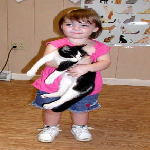

In [50]:
# visualize a sample image
print(train_imgs[0].shape)
array_to_img(train_imgs[15])

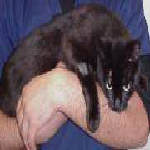

In [51]:
array_to_img(validation_imgs[15])

##### convert labels to numeric

In [52]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

In [53]:
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc      = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

In [54]:
le.classes_

array(['cat', 'dog'], dtype='<U3')

In [55]:
print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'dog', 'dog', 'dog', 'dog'] [1 1 1 1 1]


#### Basic CNN model

- with three convolutional layers, 
- coupled with max pooling for auto-extraction of features from our images and 
- also downsampling the output convolution feature maps. 

- After extracting these feature maps, we will use one dense layer along with an output layer with a sigmoid function for classification. 
- Since we are doing binary classification, a `binary_crossentropy loss` function will suffice. 
- We will use the popular `RMSprop` optimizer, which helps us in optimizing the weights of the units in our network using backpropagation so that we minimize the loss in our network and, in turn, we end up with a decent classifier. 

In [22]:
#!pip install git+https://github.com/tensorflow/docs

In [24]:
#!pip install tensorflow_docs

In [56]:
import tensorflow
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras import optimizers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [58]:
batch_size  = 30
num_classes = 2
epochs      = 30
input_shape = (150, 150, 3)

In [59]:
model = Sequential()

# convolution and pooling layers
model.add(Conv2D(filters= 16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [60]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
history = model.fit(x              = train_imgs_scaled, 
                    y              = train_labels_enc,
                    validation_data= (validation_imgs_scaled, validation_labels_enc),
                    batch_size     = batch_size,
                    epochs         = epochs,
                    verbose        = 1,
                    callbacks      = [early_stop, tfdocs.modeling.EpochDots()])

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.7799 - accuracy: 0.5100
Epoch: 0, accuracy:0.5100,  loss:0.7799,  val_accuracy:0.5000,  val_loss:0.6922,  
50/50 [==============================] - 45s 816ms/step - loss: 0.7799 - accuracy: 0.5100 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/30
50/50 [==============================] - 43s 862ms/step - loss: 0.7007 - accuracy: 0.5600 - val_loss: 0.6978 - val_accuracy: 0.5000
Epoch 3/30
50/50 [==============================] - 42s 832ms/step - loss: 0.6724 - accuracy: 0.6027 - val_loss: 0.6442 - val_accuracy: 0.6450
Epoch 4/30
50/50 [==============================] - 41s 814ms/step - loss: 0.6303 - accuracy: 0.6740 - val_loss: 0.5966 - val_accuracy: 0.7000
Epoch 5/30
50/50 [==============================] - 41s 819ms/step - loss: 0.5811 - accuracy: 0.7020 - val_loss: 0.5965 - val_accuracy: 0.6900
Epoch 6/30
50/50 [==============================] - 40s 805ms/step - loss: 0.5321 - accuracy: 0.7360 - val_loss: 0.6259

Looks like our model is `overfitting`, based on the training and validation accuracy values. 

We can plot our model accuracy and errors using the following snippet to get a better perspective:

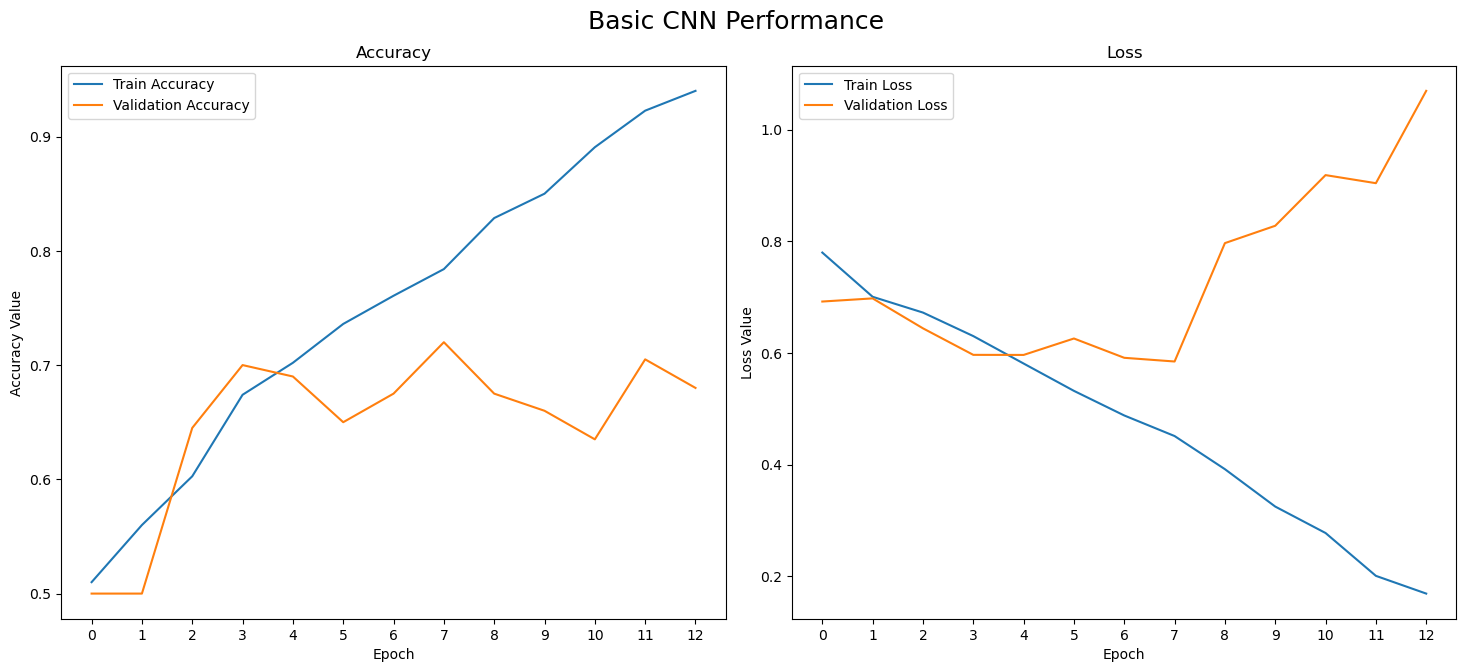

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
t = f.suptitle('Basic CNN Performance', fontsize=18)
f.subplots_adjust(top=0.9, wspace=0.1)

# plot accuracy metric
ax1.plot(range(len(history.history['accuracy'])), history.history['accuracy'],     label='Train Accuracy')
ax1.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, len(history.history['accuracy']), 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

# plot loss metric
ax2.plot(range(len(history.history['accuracy'])), history.history['loss'],     label='Train Loss')
ax2.plot(range(len(history.history['accuracy'])), history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(0, len(history.history['accuracy']), 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

You can clearly see that after 2-3 epochs the model `starts overfitting` on the training data. The `average accuracy` we get in our `validation set` is around `72%`, which is not a bad start!

#### Saving model/parameters

In [63]:
import pickle
import os

In [65]:
def model_save(model, encoder, model_save_path):
    _create_folder_if_it_doesnt_exist(model_save_path)
    _save_parameters(model_save_path)
    _save_weights(model_save_path)
    _save_encoder(model_save_path, encoder)

def _create_folder_if_it_doesnt_exist(model_save_path):
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

def _save_parameters(model_save_path):
    parameters = [
        input_shape,
    ]
    save_parameters_file = os.path.join(model_save_path, "01_basic_CNN_parameters.pkl")
    with open(save_parameters_file, "wb") as f:
        pickle.dump(parameters, f)

def _save_weights(model_save_path):
    save_weights_file = os.path.join(model_save_path, "01_basic_CNN_weights.h5")
    model.save_weights(save_weights_file)
    
def _save_encoder(model_save_path, encoder):
    save_encoder_file = os.path.join(model_save_path, "01_basic_CNN_encoder.pkl")
    with open(save_encoder_file, "wb") as f:
        pickle.dump(encoder, f)

In [66]:
model_save_path = './transfer_learning_models_save'

model_save(model=model, encoder=le, model_save_path=model_save_path)